In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import pysal as ps
import geopandas as gpd
import libpysal as lps
import sys
import platform
import zipfile
import os
from datetime import datetime
import time

import seaborn as sns
sns.set(style="darkgrid") # set style

print(sys.version_info)
print("Python Version: " + str(platform.python_version()))

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
Python Version: 3.7.3


In [2]:
# modeling packages
from  statsmodels.api import OLS
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from pysal.model import *
from pysal.explore.esda.moran import Moran
from scipy import stats
from pysal.lib.weights.weights import W
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence
from pdpbox import info_plots

In [3]:
def analyze_preds_true(preds_y, true_y):
    """Code to analyze MSE, worst errors, plot residuals"""
    resids = preds_y - true_y
    print('Residual distribution:\n',stats.describe(resids))
    print('\nMSE:',mean_squared_error(true_y, preds_y))
    ## plot 1 is just pred vs true y
    sns.scatterplot(x=preds_y, y=true_y)
    plt.xlabel("Predictions")
    plt.ylabel("True")
    plt.title("Preds vs True")
    plt.show()
    ## plot 2 is redisuals
    sns.residplot(x=preds_y, y=resids,
                  lowess=True, 
                  scatter_kws={'alpha': 0.5}, 
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.title("Residual Plots")
    plt.show()

In [4]:
## create two train and test files, 
def create_train_test(data, cols, test_year, y_col):
    prev_year = test_year - 1
    X_train_all = data.query('year!=@test_year')[cols]
    y_train_all = data.query('year!=@test_year')[y_col]
    X_train_prevyear = data.query('year==@prev_year')[cols]
    y_train_prevyear = data.query('year==@prev_year')[y_col]
    
    X_test = data.query('year==@test_year')[cols]
    y_test = data.query('year==@test_year')[y_col]
    ## quick checks
    assert X_train_all.shape[0] == len(y_train_all) 
    assert X_train_prevyear.shape[0] == len(y_train_prevyear) 
    assert X_test.shape[0] == len(y_test) 
    assert X_train_all.shape[1] == len(cols) 
    print('There are %s training obs and %s test obs' % (len(y_train_all), len(y_test)))
    
    return(X_train_all, y_train_all, X_train_prevyear, y_train_prevyear, X_test, y_test)



In [5]:
def grid_search(model, param_search, scoring, X_train, Y_train, cv, refit='neg_mean_squared_error'):
    """Function for grid search and return best estimator
    Options:
    Regression
    ‘explained_variance’: metrics.explained_variance_score
    ‘neg_mean_absolute_error’: metrics.mean_absolute_error
    ‘neg_mean_squared_error’: metrics.mean_squared_error
    ‘neg_mean_squared_log_error’: metrics.mean_squared_log_error
    ‘neg_median_absolute_error’: metrics.median_absolute_error
    ‘r2’: metrics.r2_score

    """
    grid = GridSearchCV(estimator=model, cv=cv,
                        param_grid=param_search, scoring = scoring,
                        refit=refit, return_train_score=True, verbose=1) # metric b/c balanced data set

    gs = grid.fit(X_train, Y_train)
    best_model = gs.best_estimator_ # based on roc_auc score
    return(gs, best_model)

In [6]:
def visualize_parameter_relations(df, x_feature_names, y_col, show_percentile=False):
    """Visualize parameter relationships based on info_plots"""
    # replace _ with sspace and prop case for feature name
    summary_dfs_dict = {}
    cleaned_names = [f.replace("_", " ") for f in x_feature_names]
    
    for f, n in zip(x_feature_names, cleaned_names):
        fig, axes, summary_dfs_dict[f] = info_plots.target_plot(df=yearly_data2.query('year!=2017'), 
                                                       feature=f, 
                                                       feature_name=n,
                                                       target=y_col,
                                                       show_percentile=show_percentile)
        plt.show()
    return(summary_dfs_dict)

## Modeling from Common Variables
Convert from weekly to yearly and start there.

In [7]:
malvika_url = "https://raw.githubusercontent.com/malvikarajeev/sfcrimeanalysis/master/weekly_crime_counts_with_varaibles.csv"
addtl_data = pd.read_csv(malvika_url, index_col=0)
addtl_data['GEOID'] = [str(g).rjust(11, '0') for g in addtl_data['GEOID']]
addtl_data.head(5)

,year,GEOID,week,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
1,2010,06075010100,1,34,4,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
2,2010,06075010100,2,29,9,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
3,2010,06075010100,3,21,6,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
4,2010,06075010100,4,21,15,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
5,2010,06075010100,5,22,6,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472


In [8]:
yearly_agg_data = addtl_data[['year','GEOID','N','N_calls_311']].groupby(['year','GEOID']).sum().reset_index()
yearly_agg_data.head(5)

,year,GEOID,N,N_calls_311
0,2010,06075010100,1604,600
1,2010,06075010200,823,634
2,2010,06075010300,234,445
3,2010,06075010400,289,599
4,2010,06075010500,1096,663


In [9]:
census_vars = addtl_data.drop(['week','N','N_calls_311'], axis=1).groupby(['year','GEOID']).mean().reset_index()
census_vars.head(5)

,year,GEOID,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
0,2010,06075010100,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472
1,2010,06075010200,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294
2,2010,06075010300,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169
3,2010,06075010400,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725
4,2010,06075010500,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299


In [10]:
yearly_data2 = yearly_agg_data.merge(census_vars, left_on=['year','GEOID'], right_on=['year','GEOID'], how='inner')
yearly_data2.head(5)

,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
0,2010,06075010100,1604,600,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472
1,2010,06075010200,823,634,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294
2,2010,06075010300,234,445,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169
3,2010,06075010400,289,599,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725
4,2010,06075010500,1096,663,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299


In [11]:
yearly_data2.tail(5)

,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
1555,2017,06075980200,35,137,304,0.395973,0.792763,0.967105,0.959596,0.724832,0.194079,58,64.346717,81.24,0.601974
1556,2017,06075980300,1953,4119,84,0.333333,0.607143,1.000000,1.000000,0.000000,0.261905,0,59.396970,24.91,0.261905
1557,2017,06075980501,235,1951,782,0.343558,0.434783,0.812020,0.632992,0.260123,0.083120,270,147.078210,45.93,0.588235
1558,2017,06075980600,66,211,513,0.403651,0.567251,0.826511,0.623782,1.484787,0.120858,235,89.802561,82.28,0.493177
1559,2017,06075980900,1797,7159,242,0.374815,0.557851,0.760331,0.826446,0.091852,0.152893,21,111.722871,60.36,0.355372


In [12]:
yearly_data2['rate'] = yearly_data2['N'] / yearly_data2['Estimate_Total']
yearly_data2['log_count'] = np.log(yearly_data2['N'])
yearly_data2['log_rate'] = np.log(yearly_data2['rate'])
yearly_data2.head(5)

,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class,rate,log_count,log_rate
0,2010,06075010100,1604,600,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472,0.428419,7.380256,-0.847654
1,2010,06075010200,823,634,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294,0.196702,6.712956,-1.626067
2,2010,06075010300,234,445,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169,0.054609,5.455321,-2.907555
3,2010,06075010400,289,599,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725,0.069571,5.666427,-2.665400
4,2010,06075010500,1096,663,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299,0.451214,6.999422,-0.795812


In [13]:
shapefile0 = gpd.read_file("tl_2010_06_tract10/tl_2010_06_tract10.shp")
shapefile = shapefile0.query("COUNTYFP10=='075' and ALAND10>0") # grab tracts with land 
shapefile.index = list(range(shapefile.shape[0])) # GEOID10 is match with R 
shapefile.head(5)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,+37.7741958,-122.4477884,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,06,075,016400,06075016400,164,Census Tract 164,G5020,S,309097,0,+37.7750995,-122.4369729,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,06,075,016300,06075016300,163,Census Tract 163,G5020,S,245867,0,+37.7760456,-122.4295509,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,06,075,016100,06075016100,161,Census Tract 161,G5020,S,368901,0,+37.7799831,-122.4286631,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,06,075,016000,06075016000,160,Census Tract 160,G5020,S,158236,0,+37.7823363,-122.4224838,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


In [14]:
spatial_census = pd.merge(shapefile, yearly_data2, left_on='GEOID10', right_on='GEOID', how='inner')
spatial_census = spatial_census.select_dtypes(exclude='object')
spatial_census.head(5)

,ALAND10,AWATER10,year,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class,rate,log_count,log_rate
0,370459,0,2010,630,900,4812,0.355994,0.487323,0.860973,0.892645,0.312413,0.222361,396,2612.052450,931.67,0.500416,0.130923,6.445720,-2.033148
1,370459,0,2011,619,1123,5098,0.345560,0.484504,0.883288,0.866613,0.274818,0.232052,331,2573.161577,894.45,0.487838,0.121420,6.428105,-2.108498
2,370459,0,2012,665,1239,5166,0.343240,0.500387,0.873209,0.838458,0.222263,0.173248,516,2397.091988,881.33,0.496903,0.128726,6.499787,-2.050067
3,370459,0,2013,871,1225,5289,0.340747,0.477973,0.883343,0.850349,0.202259,0.202307,446,2552.655480,906.67,0.471356,0.164681,6.769642,-1.803742
4,370459,0,2014,850,1463,5787,0.337359,0.463453,0.850527,0.864932,0.223764,0.148609,1071,2915.401259,1019.72,0.487126,0.146881,6.745236,-1.918133


### Create Clusters Based on Neighborhood Characteristics

In [15]:
## to do later

## Create Training and Test Data

In [16]:
x_cols = [col for col in list(spatial_census) if col not in ['year','N','rate','log_rate','log_count']]
print(x_cols)
X_train_all, y_train_all, X_train2016, y_train2016, X_test, y_test = create_train_test(spatial_census,
                                                                                       cols=x_cols,
                                                                                       test_year=2017,
                                                                                       y_col='log_count')

['ALAND10', 'AWATER10', 'N_calls_311', 'Estimate_Total', 'prop_rented', 'prop_male', 'prop_african_american', 'prop_under_poverty_level', 'prop_vacant_houses', 'prop_stable', 'racial_index', 'income_index', 'age_index', 'working_class']
There are 1365 training obs and 195 test obs


In [17]:
# relationship_dict = visualize_parameter_relations(spatial_census.query('year!=2017'),
#                                                   x_cols, 
#                                                   'log_count', 
#                                                   show_percentile=False)

In [18]:
list(spatial_census)

['ALAND10',
 'AWATER10',
 'year',
 'N',
 'N_calls_311',
 'Estimate_Total',
 'prop_rented',
 'prop_male',
 'prop_african_american',
 'prop_under_poverty_level',
 'prop_vacant_houses',
 'prop_stable',
 'racial_index',
 'income_index',
 'age_index',
 'working_class',
 'rate',
 'log_count',
 'log_rate']

#### Create Customer CV Splits
Because our data is time series, we can't use a normal cross validation. Therefore we need to pick priors. The code below gets indices to create 5 splits where each split is:

* train: 2010; test: 2011
* train: 2010, 2011; test: 2012
* train: 2010, 2011, 2012; test: 2013
* train: 2010, 2011, 2012, 2013; test: 2014
* train: 2010, 2011, 2012, 2013, 2014; test: 2015
* train: 2010, 2011, 2012, 2013, 2014, 2015; test: 2016


In [19]:
groups = yearly_data2.query('year!=2017').groupby(yearly_data2.query('year!=2017')['year']).groups
#groups[2010].values
# {2012: [0, 1], 2013: [2], 2014: [3], 2015: [4, 5]}
sorted_groups = [list(indices.values) for (key, indices) in sorted(groups.items())] 
# # [[0, 1], [2], [3], [4, 5]]
#sorted_groups
cv = [(np.array(sum( sorted_groups[:(i-1)], [])), np.array(sorted_groups[i]))
      for i in range(len(sorted_groups)-1,1,-1)]

scoring = 'neg_mean_squared_error'

## Models using 2010-2016
1. RF
2. LR
3. Spatial LR

### Random Forest

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.8s finished


Residual distribution:
 DescribeResult(nobs=195, minmax=(-0.9717884600528199, 1.1055018297246004), mean=0.14082466904506985, variance=0.1174784767733813, skewness=-0.2649769133051771, kurtosis=0.5276115804923864)

MSE: 0.13670761045799176


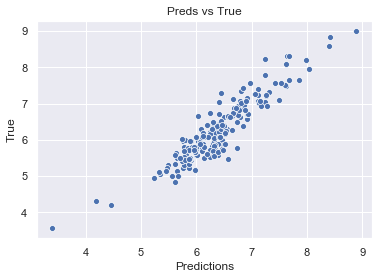

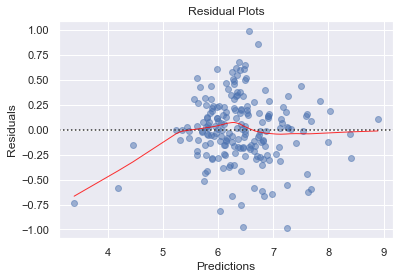

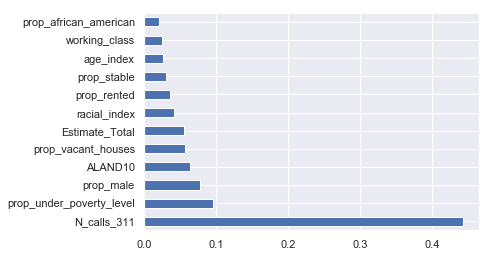

In [20]:
rf_tree = RandomForestRegressor(random_state=0) 
param_search_rf = {'max_depth' : [None, 2, 3, 5, 10],
                   'n_estimators': [10, 50, 100, 200 ]}

grid_rf, best_rf = grid_search(model=rf_tree, param_search=param_search_rf, scoring=scoring,
                               X_train=X_train_all, Y_train = y_train_all, cv=cv, refit='neg_mean_squared_error')
best_rf.fit(X_train_all, y_train_all)  

y_pred_rf = best_rf.predict(X_test)

analyze_preds_true(y_pred_rf, y_test)  # for model


feat_importances = pd.Series(best_rf.feature_importances_, index=x_cols)
feat_importances.nlargest(12).plot(kind='barh')

In [21]:
# plot_partial_dependence(best_rf, X_train_all, x_cols,
#                                        feature_names=x_cols,
#                                        n_jobs=3, grid_resolution=50)
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

### Linear Regression

In [22]:
lr_all = OLS(y_train_all,X_train_all).fit()
lr_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_count   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.144e+04
Date:                Thu, 25 Apr 2019   Prob (F-statistic):               0.00
Time:                        13:04:52   Log-Likelihood:                -1170.5
No. Observations:                1365   AIC:                             2369.
Df Residuals:                    1351   BIC:                             2442.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ALAND10                  -5.013e-10   2.41e-08     -0.021      0.983   -4.78e-08    4.68e-08
AWATER10                 -1.376e-08    1.9e-09     -7.236      0.000   -1.75e-08      -1e-08
N_calls_311                  0.0002    1.4e-05     16.871      0.000       0.000       0.000
Estimate_Total               0.0003   4.64e-05      5.530      0.000       0.000       0.000
prop_rented                 13.7980      0.927     14.878      0.000      11.979      15.617
prop_male                    2.3433      0.310      7.551      0.000       1.734       2.952
prop_african_american       -0.3058      0.171     -1.789      0.074      -0.641       0.029
prop_under_poverty_level    -0.8393      0.325     -2.579      0.010      -1.478      -0.201
prop_vacant_houses          -0.1915      0.022     -8.869      0.000      -0.234      -0.149
prop_stable                  1.5428      0.255      6.060      0.000       1.043       2.042
racial_index                 0.0003   4.43e-05      6.650      0.000       0.000       0.000
income_index                -0.0002   7.37e-05     -2.642      0.008      -0.000   -5.01e-05
age_index                   -0.0002      0.000     -1.962      0.050      -0.000   -8.04e-08
working_class                0.1616      0.169      0.958      0.338      -0.169       0.493
==============================================================================
Omnibus:                      181.942   Durbin-Watson:                   0.496
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              844.677
Skew:                          -0.540   Prob(JB):                    3.81e-184
Kurtosis:                       6.699   Cond. No.                     5.58e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.58e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Residual distribution:
 DescribeResult(nobs=195, minmax=(-1.921979195761046, 3.007661117909605), mean=0.21759307566903735, variance=0.3709633515111405, skewness=0.6516607525801905, kurtosis=3.868429902116792)

MSE: 0.4164077219286563


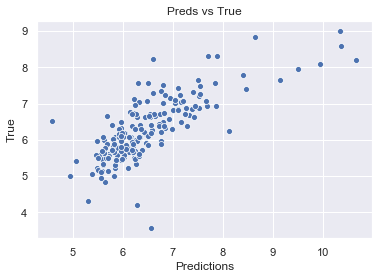

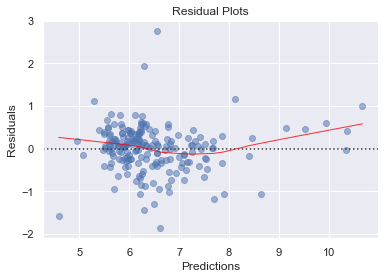

In [23]:
y_pred_lr = lr_all.predict(X_test)
analyze_preds_true(y_pred_lr, y_test)  # for model

### Lasso Linear Regression

In [24]:
X_scaler = StandardScaler()
X_scaler.fit(X_train_all)
X_train_scale = X_scaler.transform(X_train_all)
X_test_scale = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_scaler.fit(np.array(y_train_all ).reshape(-1,1))
y_train_scale = y_scaler.transform(np.array(y_train_all ).reshape(-1,1) )
y_test_scale = y_scaler.transform(np.array(y_test).reshape(-1,1))
print(X_train_scale.shape, X_train_all.shape, y_train_scale.shape)

(1365, 14) (1365, 14) (1365, 1)


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


(100, 5)


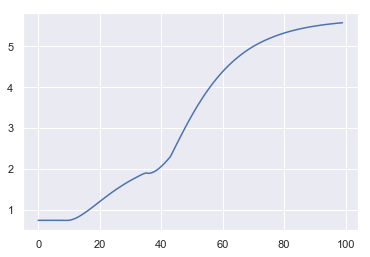

In [25]:
lasso_cv = LassoCV(cv=cv, n_alphas=100, random_state=0).fit(X_train_all, y_train_all)
print(lasso_cv.mse_path_.shape) # avg mse for each column

sns.lineplot(x=[i for i in range(100)], y=np.mean(lasso_cv.mse_path_, axis=1))

Computing regularization path using the coordinate descent lasso...
Alpha to choose is  0.12555050164221074


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


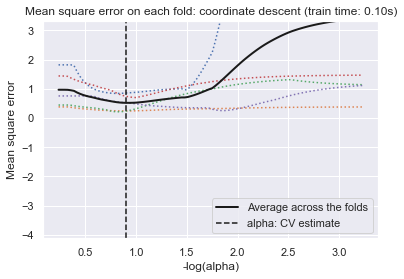

In [26]:
# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
lasso_cv = LassoCV(cv=cv).fit(X_train_scale, y_train_scale)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(lasso_cv.alphas_)

plt.figure()
ymin, ymax = np.min(y_train_scale), np.max(y_train_scale)
plt.plot(m_log_alphas, lasso_cv.mse_path_, ':')
plt.plot(m_log_alphas, lasso_cv.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(lasso_cv.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

best_alpha = lasso_cv.alphas_[np.argmin(lasso_cv.mse_path_.mean(axis=-1))]

print('Alpha to choose is ', best_alpha)

dropping ALAND10
dropping AWATER10
N_calls_311 has coef 0.37384722733110143
dropping Estimate_Total
dropping prop_rented
prop_male has coef 0.030147742018675046
dropping prop_african_american
prop_under_poverty_level has coef -0.15564080635263494
prop_vacant_houses has coef -0.0399376897907924
prop_stable has coef 0.033899831986191654
racial_index has coef 0.0986218027409167
dropping income_index
age_index has coef 0.0699140916786428
dropping working_class


Residual distribution:
 DescribeResult(nobs=195, minmax=(-1.6628082278896494, 2.151291374433726), mean=0.23561547938548744, variance=0.30868540676924966, skewness=0.12469421786616114, kurtosis=2.0372892065957267)

MSE: 0.36261705880930656


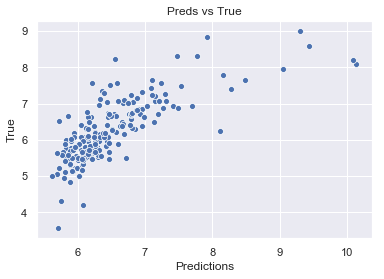

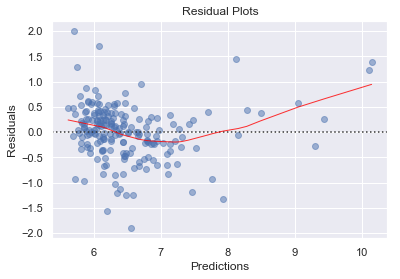

In [42]:
best_lasso = Lasso(alpha=best_alpha).fit(X_train_scale, y_train_scale)
for c, col in zip(best_lasso.coef_, x_cols):
    if c==0:
        print('dropping %s' % col)
    else:
        print("%s has coef %s" % (col, c))
print('\n')
best_lasso_pred = y_scaler.inverse_transform(best_lasso.predict(X_test_scale))
analyze_preds_true(best_lasso_pred, y_test)

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


Text(0.5, 1.0, 'Information-criterion for model selection (training time 0.007s)')

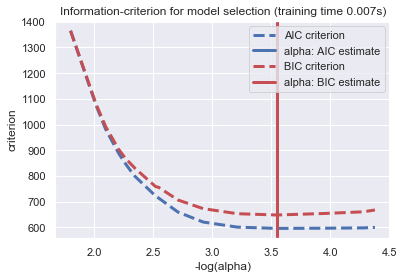

In [28]:
model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X_train_scale, y_train_scale)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train_scale, y_train_scale)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

Note, the errors have outliers and hint that this model, although low MSE, isn't fitting properly.

## Models with just 2016 to predict 2017

## RF

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.8s finished


Residual distribution:
 DescribeResult(nobs=195, minmax=(-1.1090862191268753, 1.30695448279518), mean=0.06354286660555017, variance=0.11582544322304929, skewness=-0.2030809458676886, kurtosis=1.331206589127242)

MSE: 0.11926916248758695


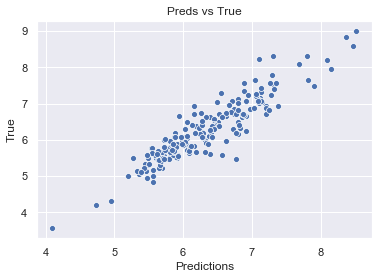

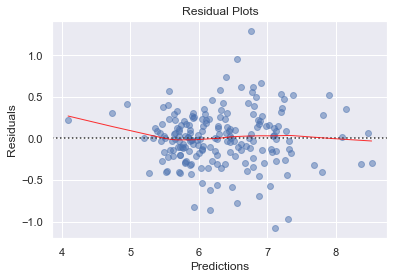

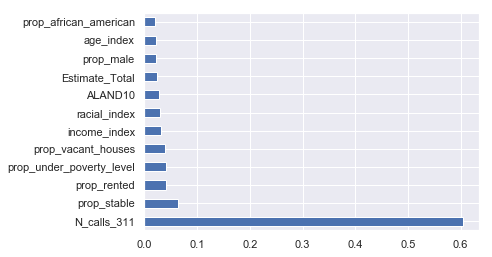

In [29]:
rf_tree = RandomForestRegressor(random_state=0)  

param_search_rf = {'max_depth' : [None, 2, 3, 5, 10],
                   'n_estimators': [10, 50, 100, 200 ]}

grid_rf2016, best_rf2016 = grid_search(model=rf_tree, param_search=param_search_rf, scoring=scoring,
                               X_train=X_train_all, Y_train = y_train_all, cv=cv, refit='neg_mean_squared_error')

best_rf2016.fit(X_train2016, y_train2016)  

y_pred_rf = best_rf2016.predict(X_test)

analyze_preds_true(y_pred_rf, y_test)  # for model


feat_importances = pd.Series(best_rf2016.feature_importances_, index=x_cols)
feat_importances.nlargest(12).plot(kind='barh')

## Linear Regression

In [30]:
lr2016 = OLS(y_train_all,X_train_all).fit()
lr2016.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_count   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.144e+04
Date:                Thu, 25 Apr 2019   Prob (F-statistic):               0.00
Time:                        13:05:17   Log-Likelihood:                -1170.5
No. Observations:                1365   AIC:                             2369.
Df Residuals:                    1351   BIC:                             2442.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ALAND10                  -5.013e-10   2.41e-08     -0.021      0.983   -4.78e-08    4.68e-08
AWATER10                 -1.376e-08    1.9e-09     -7.236      0.000   -1.75e-08      -1e-08
N_calls_311                  0.0002    1.4e-05     16.871      0.000       0.000       0.000
Estimate_Total               0.0003   4.64e-05      5.530      0.000       0.000       0.000
prop_rented                 13.7980      0.927     14.878      0.000      11.979      15.617
prop_male                    2.3433      0.310      7.551      0.000       1.734       2.952
prop_african_american       -0.3058      0.171     -1.789      0.074      -0.641       0.029
prop_under_poverty_level    -0.8393      0.325     -2.579      0.010      -1.478      -0.201
prop_vacant_houses          -0.1915      0.022     -8.869      0.000      -0.234      -0.149
prop_stable                  1.5428      0.255      6.060      0.000       1.043       2.042
racial_index                 0.0003   4.43e-05      6.650      0.000       0.000       0.000
income_index                -0.0002   7.37e-05     -2.642      0.008      -0.000   -5.01e-05
age_index                   -0.0002      0.000     -1.962      0.050      -0.000   -8.04e-08
working_class                0.1616      0.169      0.958      0.338      -0.169       0.493
==============================================================================
Omnibus:                      181.942   Durbin-Watson:                   0.496
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              844.677
Skew:                          -0.540   Prob(JB):                    3.81e-184
Kurtosis:                       6.699   Cond. No.                     5.58e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.58e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Residual distribution:
 DescribeResult(nobs=195, minmax=(-1.921979195761046, 3.007661117909605), mean=0.21759307566903735, variance=0.3709633515111405, skewness=0.6516607525801905, kurtosis=3.868429902116792)

MSE: 0.4164077219286563


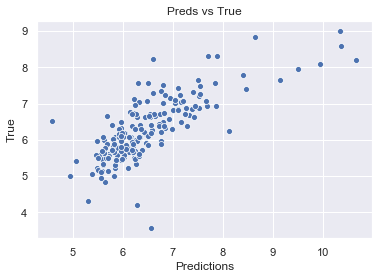

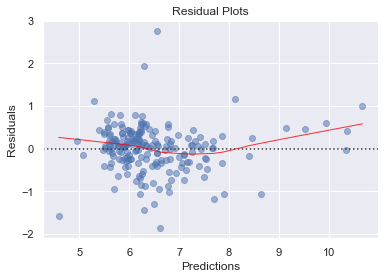

In [31]:
y_pred_lr = lr2016.predict(X_test)
analyze_preds_true(y_pred_lr, y_test)  # for model

### Linear Regression with Spatial

In [32]:
## shapefile load in
shapefile0 = gpd.read_file("tl_2010_06_tract10/tl_2010_06_tract10.shp")
shapefile = shapefile0.query("COUNTYFP10=='075' and ALAND10>0") # grab tracts with land 
shapefile.index = list(range(shapefile.shape[0])) # GEOID10 is match with R 
shapefile.head(5)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,+37.7741958,-122.4477884,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,06,075,016400,06075016400,164,Census Tract 164,G5020,S,309097,0,+37.7750995,-122.4369729,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,06,075,016300,06075016300,163,Census Tract 163,G5020,S,245867,0,+37.7760456,-122.4295509,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,06,075,016100,06075016100,161,Census Tract 161,G5020,S,368901,0,+37.7799831,-122.4286631,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,06,075,016000,06075016000,160,Census Tract 160,G5020,S,158236,0,+37.7823363,-122.4224838,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


In [33]:
spatial_census = pd.merge(shapefile, yearly_data2, left_on='GEOID10', right_on='GEOID', how='inner')
spatial_census.head(5)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,...,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class,rate,log_count,log_rate
0,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,...,0.892645,0.312413,0.222361,396,2612.052450,931.67,0.500416,0.130923,6.445720,-2.033148
1,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,...,0.866613,0.274818,0.232052,331,2573.161577,894.45,0.487838,0.121420,6.428105,-2.108498
2,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,...,0.838458,0.222263,0.173248,516,2397.091988,881.33,0.496903,0.128726,6.499787,-2.050067
3,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,...,0.850349,0.202259,0.202307,446,2552.655480,906.67,0.471356,0.164681,6.769642,-1.803742
4,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,...,0.864932,0.223764,0.148609,1071,2915.401259,1019.72,0.487126,0.146881,6.745236,-1.918133


#### Helper functions to create spatial data

In [34]:
def create_shp_year(data, year, location, fn):
    clean_sf_link = location + fn + str(year)
    clean_sf_shp = clean_sf_link + '.shp'
    data0 = data.query('year==@year').reset_index()
    data0 = data0.drop('index', axis=1)
    shaped_data = gpd.GeoDataFrame(data0)
    shaped_data.to_file(clean_sf_shp)
    return(data0)

def create_neighbors(shape_file_location):
    qW = lps.weights.Queen.from_shapefile(shape_file_location, 'GEOID')
    qW.transform='r'
    rW = lps.weights.Rook.from_shapefile(shape_file_location, 'GEOID')
    rW.transform='r'
    bW = lps.weights.w_difference(qW, rW, constrained=False) 
    bW.transform='r'
    return qW, rW, bW

def basic_analysis(start_year, end_year, data, location, fn):
    dict_data = {}
    morans_data = pd.DataFrame()
    for y in range(start_year, end_year+1):
        print('starting year ' + str(y))
        data_yr = create_shp_year(data, int(y), location, fn)
        qW, rW, bW = create_neighbors(location + fn + str(y) + '.shp')
        for weight_type, w in zip(['queen','rook','bishop'], [qW, rW, bW]):
            ## get Moran data for all combos and weights...
            mi = Moran(y= np.array(data_yr['log_count']), w=w)
            morans_data = morans_data.append({'year': y, 'weight':weight_type, 'moran_i':mi.I, 
                                   'moran_z': mi.z_norm, 'moran_p':mi.p_norm}, ignore_index=True)
        dict_data[y] = {'data':data_yr, 'qW':qW, 'rW':rW, 'bW':bW}
        
    return(dict_data, morans_data)

def spatial_model_model_type(data, year, cols, y_col = 'log_count', weight='queen', model_type='ols'):
    tmp_data = data[year]['data']
    y = np.array(tmp_data['log_count'])
    y = np.resize(y, [len(y), 1])
    x = np.array(tmp_data[cols])
    
    next_year = year + 1
    y_true = data[next_year]['data'][y_col]
    X_test_pysal = data[next_year]['data'][cols].copy()
    
    if weight=='queen':
        w = data[year]['qW']
    else:
        w = data[year]['rW']
    
    w_obj = W(w.neighbors, w.weights)
    X_test_pysal['intercept'] = 1
    X_test_pysal['w_lag'] = 1 
        
    if model_type=='ols':
        model = spreg.OLS(y, x, w=w_obj, name_y=y_col, 
                          name_x=cols,
                          name_ds='censusdata', spat_diag = True)
        X_test_pysal = np.array(X_test_pysal.reindex(['intercept'] + cols, axis=1))
    elif model_type=='lag':
        model = spreg.ML_Lag(y, x, w=w_obj, name_y=y_col, 
                          name_x=cols,
                          name_ds='censusdata', spat_diag = True)
        X_test_pysal = np.array(X_test_pysal.reindex(['intercept'] + cols + ['w_lag'], axis=1))
        
        #lag_spatial(w_obj, y_) doesnt make sense tho b/c we wont have y
        
#     elif model_type=='GWR':
#         model = spreg.GWR(y, x, w=w_obj, name_y=y_col, 
#                           name_x=cols,
#                           name_ds='censusdata', spat_diag = True)
    ## get resids for year and then test year
    y_preds = X_test_pysal.dot(model.betas)
    
    return(model, y_preds, y_true)

In [35]:
yearly_data, morans_data = basic_analysis(2010, 2017, 
                                          spatial_census, 
                                          '../../data/', 
                                          'clean_sf_tracts_with_features_simple')

starting year 2010


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

starting year 2013
('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WAR

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

starting year 2015
('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WAR

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

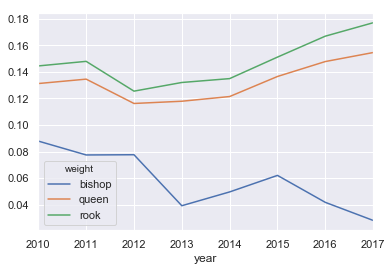

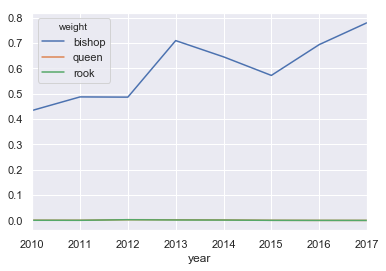

In [36]:
## use only rooks or queen's distance
pd.pivot_table(morans_data, values='moran_i', columns='weight', index='year').plot()
pd.pivot_table(morans_data, values='moran_p', columns='weight', index='year').plot()

In [37]:
model, y_preds_spatial, y_true_spatial = spatial_model_model_type(yearly_data, 2016, x_cols, y_col = 'log_count', weight='rook')
print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :  censusdata
Weights matrix      :     unknown
Dependent Variable  :   log_count                Number of Observations:         195
Mean dependent var  :      6.2315                Number of Variables   :          15
S.D. dependent var  :      0.8479                Degrees of Freedom    :         180
R-squared           :      0.6406
Adjusted R-squared  :      0.6127
Sum squared residual:      50.121                F-statistic           :     22.9207
Sigma-square        :       0.278                Prob(F-statistic)     :   6.618e-33
S.E. of regression  :       0.528                Log likelihood        :    -144.234
Sigma-square ML     :       0.257                Akaike info criterion :     318.468
S.E of regression ML:      0.5070                Schwarz criterion     :     367.563

-----------------------------------------------------------------------------

Residual distribution:
 DescribeResult(nobs=195, minmax=(-1.7963785168163238, 2.3881426816882088), mean=0.058393242833682114, variance=0.27439110862687593, skewness=0.3180894915024553, kurtosis=3.04704823533471)

MSE: 0.2763937455451151


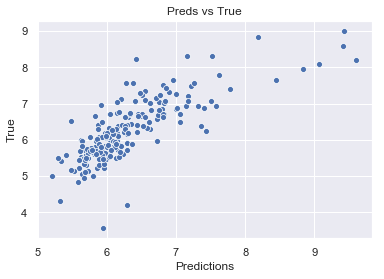

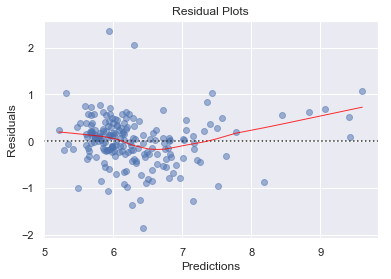

In [38]:
y_preds_spatial2 = [v[0] for v in y_preds_spatial]
analyze_preds_true(y_preds_spatial2, y_test)  # for model

In [39]:
lag_model, y_preds_lag, y_true_lag = spatial_model_model_type(yearly_data, 2016, x_cols, y_col = 'log_count', 
                                                              weight='rook', model_type='lag')

y_preds_lag2 = [v[0] for v in y_preds_lag]

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/scipy/optimize/_minimize.py:761: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


In [40]:
print(lag_model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :  censusdata
Weights matrix      :     unknown
Dependent Variable  :   log_count                Number of Observations:         195
Mean dependent var  :      6.2315                Number of Variables   :          16
S.D. dependent var  :      0.8479                Degrees of Freedom    :         179
Pseudo R-squared    :      0.6581
Spatial Pseudo R-squared:  0.6413
Sigma-square ML     :       0.245                Log likelihood        :    -140.298
S.E of regression   :       0.495                Akaike info criterion :     312.596
                                                 Schwarz criterion     :     364.964

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

Residual distribution:
 DescribeResult(nobs=195, minmax=(-2.965499992672493, 1.10450273202532), mean=-1.1054926183227638, variance=0.26769303160511176, skewness=0.13655807819486362, kurtosis=2.6150465752183063)

MSE: 1.4884341759937698


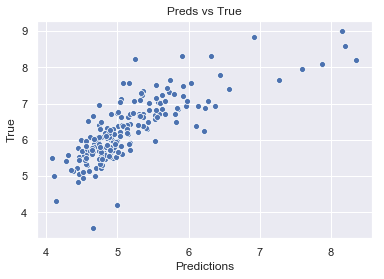

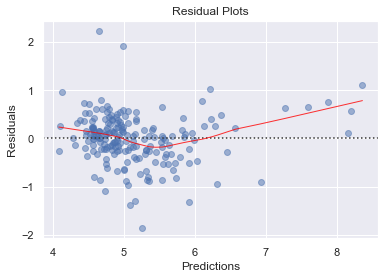

In [41]:
y_preds_lag2 = [v[0] for v in y_preds_lag]
analyze_preds_true(y_preds_lag2, y_test)  # for model